# Datafusion example

How to request Sentinel-1 and Sentinel-2 data over a given time period for all coinciding acquisitions.

In [1]:
import json
import matplotlib.pyplot as plt
from sentinelhub import (SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType)

### Set up Sentinel Hub services credentials

In [3]:
# Set credentials
client_id = ""
client_secret = ""

In [4]:
# Set up credentials for use with Sentinel Hub python package
config = SHConfig()

if client_id and client_secret:
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    
if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

### Set input parameters


In [5]:
# Set up AOI
rome = [12.44693, 41.870072, 12.541001, 41.917096]
rome_bbox = BBox(bbox=rome, crs=CRS.WGS84) 

In [6]:
# Time interval
time_interval = ('2020-10-27', '2021-01-14') 

### Run Sentinel Hub datafusion request on the common dates only

#### Build Evalscript

In the Evalscript, the dates for which the two satellites (S1 and S2) have acquisitions are filtered in the `preProcessScenes`. 

One output is created for each band. The output will contain data for each date that has a Sentinel-2 and a Sentinel-1 acquisition.


In [7]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: [{
        datasource: "S1GRD",
        bands: ["VV","VH"]
      },
      {
        datasource: "S2L2A",
        bands: ["B03"]
      }
    ],
    // For each band create an output
    output: [
      {
        id: "VV",
        bands: 1,
        sampleType: SampleType.FLOAT32
      },
      {
        id: "VH",
        bands: 1,
        sampleType: SampleType.FLOAT32
      },
      {
        id: "G",
        bands: 1,
        sampleType: SampleType.FLOAT32
      },
    ],
    mosaicking: "ORBIT"
  };
}

// Filter for common dates
function preProcessScenes (collections) {
    var s2dates = collections.S2L2A.scenes.orbits.map(function (orbit) {
        return orbit.dateFrom.split("T")[0];
    });
    var s1dates = collections.S1GRD.scenes.orbits.map(function (orbit) {
        return orbit.dateFrom.split("T")[0];
    });
    
    var allowedDates = s2dates.filter(value => s1dates.includes(value));
    
    collections.S2L2A.scenes.orbits = collections.S2L2A.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    });
    collections.S1GRD.scenes.orbits = collections.S1GRD.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    });
    return collections;
}


function updateOutput(outputs, collections) {
    n_bands = collections.S1GRD.scenes.orbits.length;
    outputs.VV.bands = n_bands;
    outputs.VH.bands = n_bands;
    outputs.G.bands = n_bands;
}

function evaluatePixel(samples) {
  // Get Sentinel-1 and Sentinel-2 data
  var s1_data = samples.S1GRD;
  var s2_data = samples.S2L2A;
  
  // Initialise bands to be written
  var vv_band = [];
  var vh_band = [];
  var b3_band = [];

  // Add Sentinel-1 data to the band array
  for (i=0; i<s1_data.length;i++){
    vv_band.push(s1_data[i].VV);
    vh_band.push(s1_data[i].VH);
  }
  
  // Add Sentinel-2 data to the band array
  for (i=0; i<s2_data.length;i++){
    b3_band.push(s2_data[i].B03);
  }
  
  // Return one file per band containing data from all dates
  return {
    VV: vv_band,
    VH: vh_band,
    G: b3_band
  };
}
"""

#### Build the request with `sentinelhub-py`

The outputs from the `evaluatePixel` function have to be specified as `responses` in the request. 

In [8]:
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW,
            time_interval=time_interval,
            other_args = {"dataFilter":{"resolution":"HIGH"},
                          "processing":{"backCoeff":"GAMMA0_TERRAIN",
                                        "orthorectify":True,
                                        "demInstance":"COPERNICUS"},
                          "id":"S1GRD"}
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            other_args = {"id":"S2L2A"}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('VV', MimeType.TIFF),
        SentinelHubRequest.output_response('VH', MimeType.TIFF),
        SentinelHubRequest.output_response('G', MimeType.TIFF)
    ],
    bbox=rome_bbox,
    config=config,
    data_folder="./data_fusion/"
)

#### Run the request and download the images

In [9]:
all_common_data = request.get_data(save_data=True)

#### Plot an example 

In the following cell, we plot the first acquisition for each band.

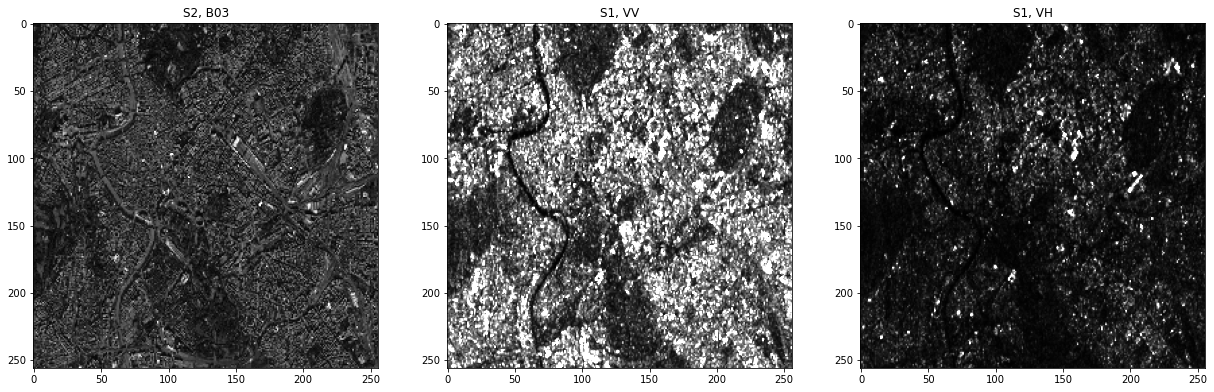

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(21,7))

# Plot first date of the three bands
ax[0].imshow(all_common_data[0]["G.tif"][:,:,0]*2.5, vmin=0, vmax=1, cmap="Greys_r")
ax[1].imshow(all_common_data[0]["VV.tif"][:,:,0], vmin=0, vmax=1, cmap="Greys_r")
ax[2].imshow(all_common_data[0]["VH.tif"][:,:,0], vmin=0, vmax=1, cmap="Greys_r")

ax[0].set_title("S2, B03")
ax[1].set_title("S1, VV")
ax[2].set_title("S1, VH")

plt.show()